In [1]:
import sys
print(f'This notebook was last run with this kernel {sys.executable}')

This notebook was last run with this kernel /home/igarzonalva/.conda/envs/scvi_cpu_env/bin/python


In [2]:
import scanpy as sc
import os
import numpy as np
import pandas as pd

os.chdir('/home/igarzonalva/Proyecto_SC_TNBC/GSE161529/02_Integration')

In [3]:
print(f'scanpy version:{sc.__version__}')

scanpy version:1.10.4


In [4]:
adata = sc.read_h5ad("./adata/adata_scvi_cuda_allvars.h5ad")
adata

AnnData object with n_obs × n_vars = 205006 × 22788
    obs: 'batch', 'subtype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'complexity', 'n_genes', 'n_counts', 'predicted_labels', 'over_clustering', 'majority_voting', 'doublet_score', 'predicted_doublet', '_scvi_batch', '_scvi_labels', 'leiden'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'leiden', 'log1p', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    layers: 'batch_corrected_counts', 'counts'
    obsp: 'connectivities', 'distances'

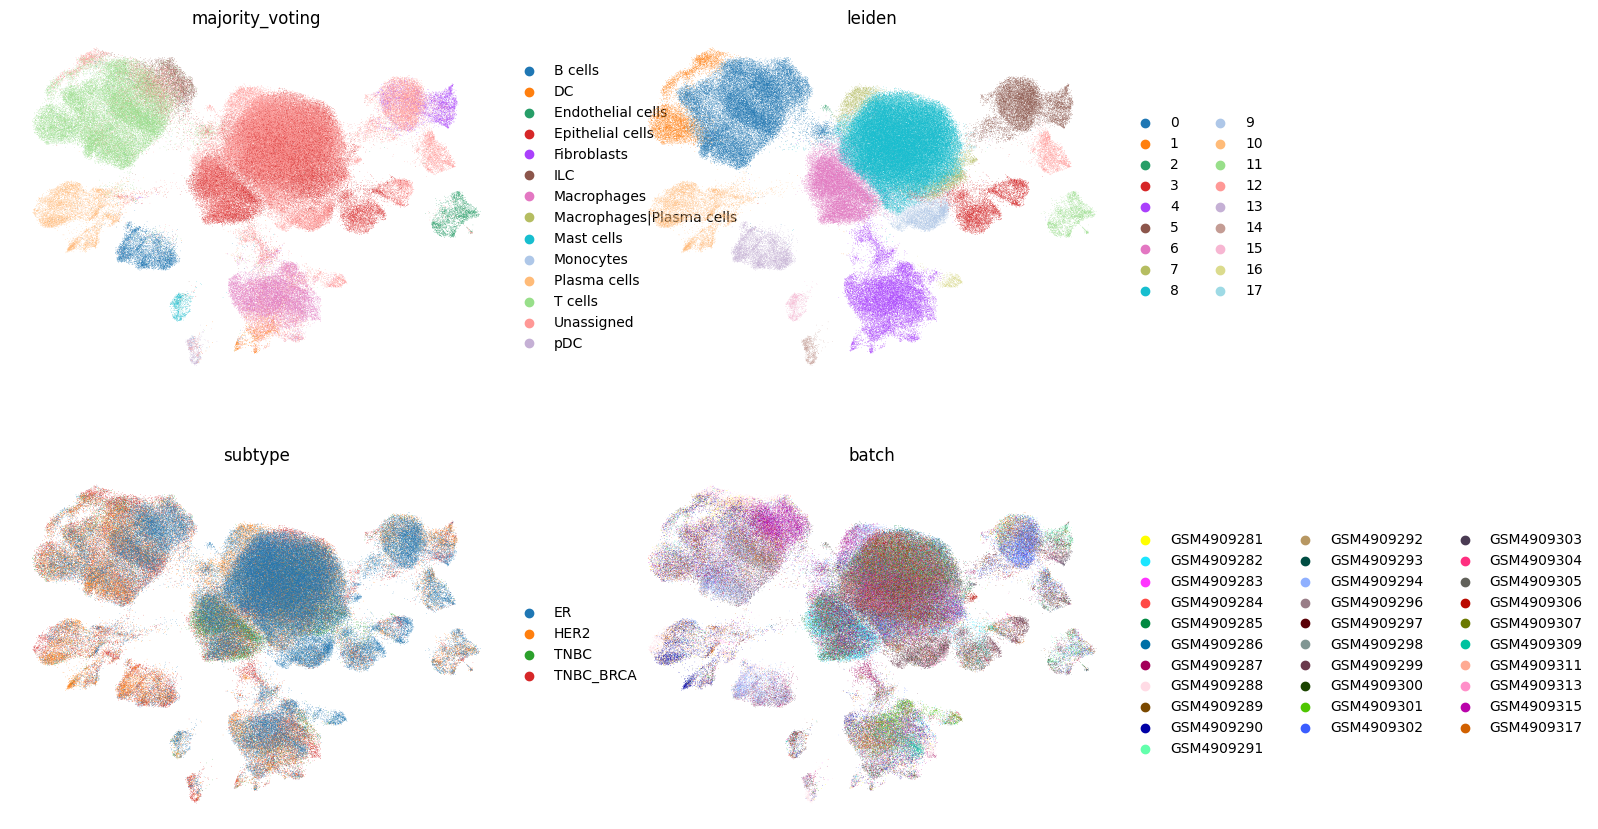

In [13]:
sc.pl.umap(
    adata, color=["majority_voting","leiden","subtype","batch"],
    #legend_loc="on data",
    frameon=False,ncols=2,use_raw = False)
    #cmap = "viridis" size = 7)

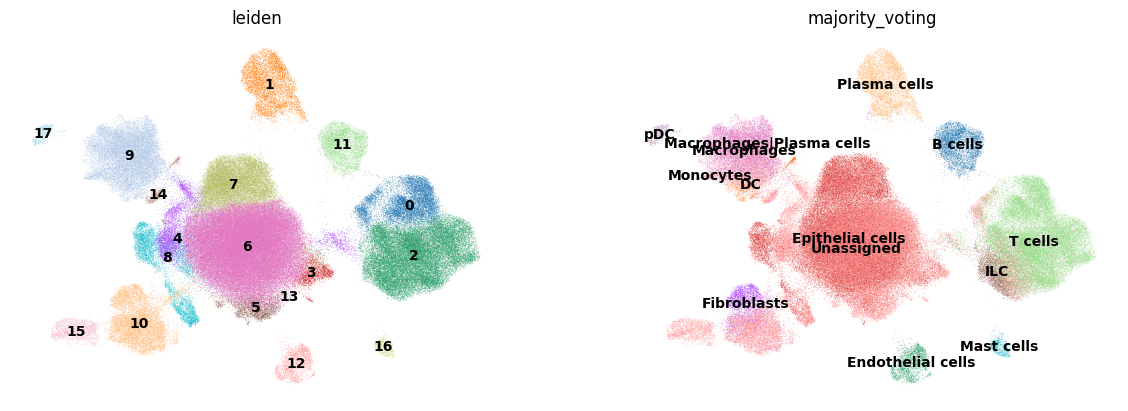

In [8]:
sc.pl.umap(
    adata, color=["leiden",'majority_voting'],
    legend_loc="on data",
    frameon=False,ncols=2,use_raw = False)
    #cmap = "viridis" size = 7)

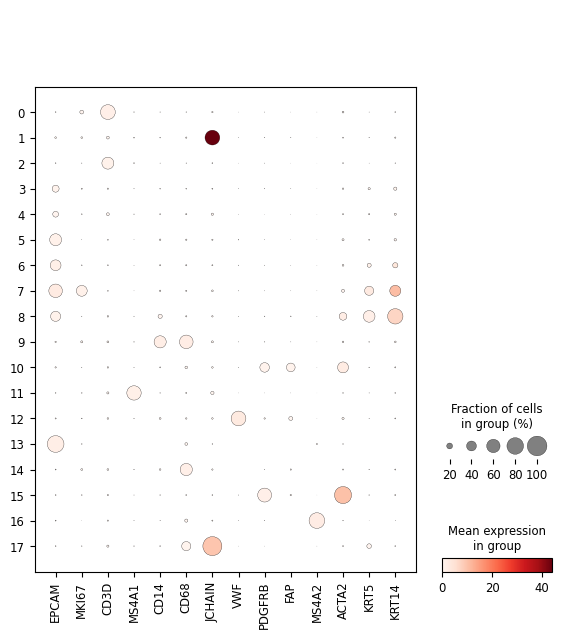

In [6]:
# "EPCAM","CDH1" epithelial
# "MKI67" proliferative
# "CD3D", T cells
# "MS4A1" B cells
# JCHAIN plasma cells
# CD14 Monocytes
# "CD68" macrophages
# "PECAM1","VWF" endothelial
# "PDGFRB","FAP" fibroblasts
# MS4A2 Mast/Basophiphs cells

general_markers  = ["EPCAM","MKI67", "CD3D", "MS4A1", "CD14", "CD68","JCHAIN", "VWF", "PDGFRB","FAP","MS4A2","ACTA2", "KRT5", "KRT14"]


#sc.pl.dotplot(adata=adata, var_names=general_markers, groupby=["leiden",'subtype'])
sc.pl.dotplot(adata=adata, var_names=general_markers, groupby=["leiden"])

In [9]:
rename_dict = {"0": "T cells",
                "1": "Plasma cells",
               "2": "T cells",
               "3": "unknown", 
               "4": "unknown",
               "5": "Epithelial",
               "6": "Epithelial",
               "7": "Cycling Epithelial",
               "8": "MioEpithelial",
               "9": "Myeloid",
               "10": "Fibroblast FAP+",
               "11": "B cells",
               "12": "Endothelial",
               "13": "unknown",
               "14": "Myeloid",
               "15": "Fibroblast FAP-", 
               "16": "Mast cells",
               "17": "Myeloid",
               }
#adata.obs['GenAnno'] = adata.obs['leiden'].replace(rename_dict)
adata.obs['IGA_First_GenAnno'] = adata.obs['leiden'].map(rename_dict).astype('category')
adata.obs['IGA_First_GenAnno'].info()
adata.obs['IGA_First_GenAnno'].value_counts()

<class 'pandas.core.series.Series'>
Index: 205006 entries, AAACCTGCAAGCGTAG-1-GSM4909281 to TTTGTTGTCTCGGTAA-1-GSM4909317
Series name: IGA_First_GenAnno
Non-Null Count   Dtype   
--------------   -----   
205006 non-null  category
dtypes: category(1)
memory usage: 9.8+ MB


IGA_First_GenAnno
Epithelial            84617
T cells               40541
Myeloid               18945
Cycling Epithelial    17407
Fibroblast FAP+       10920
unknown                8756
Plasma cells           7040
MioEpithelial          6089
B cells                5246
Endothelial            2358
Fibroblast FAP-        2261
Mast cells              826
Name: count, dtype: int64

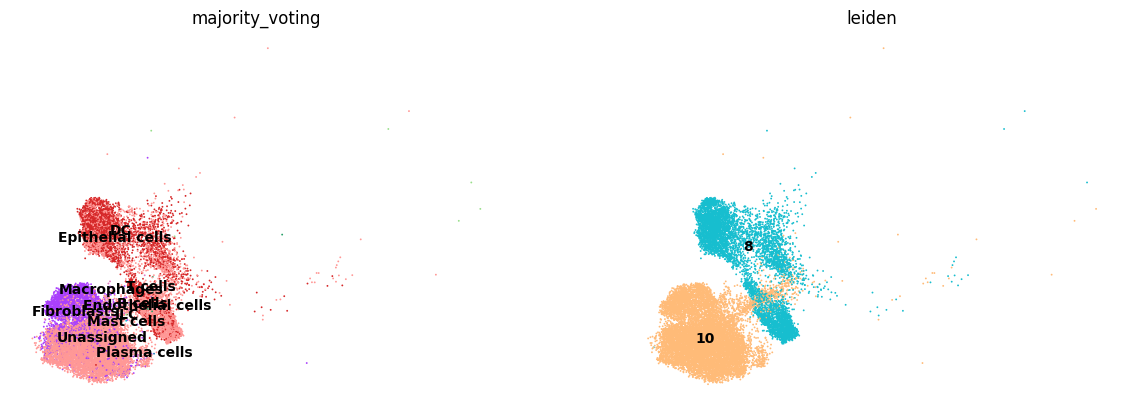

In [13]:
unkown_mask = adata.obs.leiden.isin(['10','8'])
#adata[unkown_mask,:].obs.majority_voting

sc.pl.umap(
    adata[unkown_mask,:], color=["majority_voting","leiden"],
    legend_loc="on data",
    frameon=False,ncols=2,use_raw = False)
    #cmap = "viridis" size = 7)

In [25]:
unkown_adata = adata[unkown_mask,:].copy()
unkown_cells = unkown_adata.obs.index

In [23]:
sure_epi = unkown_adata[unkown_adata.obs.majority_voting == 'Epithelial cells'].obs.index

In [24]:
sure_fibro = unkown_adata[unkown_adata.obs.majority_voting == 'Fibroblasts'].obs.index

In [27]:
unkown_adata.obs['unkown_refinement'] = 'unknown'
unkown_adata.obs.loc[sure_epi, 'unkown_refinement'] = unkown_adata.obs.loc[sure_epi, 'IGA_First_GenAnno']
unkown_adata.obs.loc[sure_fibro, 'unkown_refinement'] = unkown_adata.obs.loc[sure_fibro, 'IGA_First_GenAnno']

In [28]:
unkown_adata.obs.unkown_refinement.value_counts()

unkown_refinement
unknown            10209
MioEpithelial       3426
Fibroblast FAP+     3374
Name: count, dtype: int64

In [32]:
adata.obs["IGA_First_GenAnnoV2"] = adata.obs["IGA_First_GenAnno"]

In [33]:
adata.obs.loc[unkown_cells,'IGA_First_GenAnnoV2'] = unkown_adata.obs.loc[unkown_cells,'unkown_refinement']

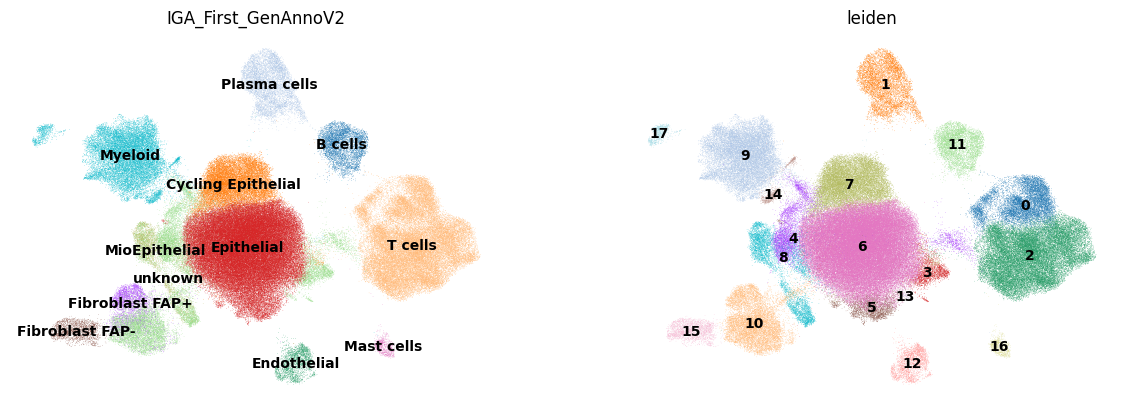

In [34]:
sc.pl.umap(
    adata, color=["IGA_First_GenAnnoV2","leiden"],
    legend_loc="on data",
    frameon=False,ncols=2,use_raw = False)
    #cmap = "viridis" size = 7)

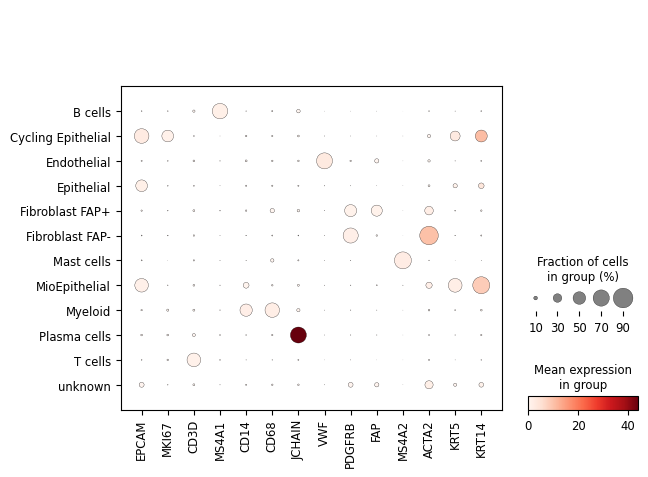

In [35]:
sc.pl.dotplot(adata=adata, var_names=general_markers, groupby=["IGA_First_GenAnnoV2"])

In [36]:
adata.write_h5ad("./adata/adata_GenAnno_allvars.h5ad")